In [ ]:
import pandas as pd
import numpy as np
import glob
import soundfile
import os
import sys

import librosa
import librosa.display
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from IPython.display import Audio 
from IPython.core.display import display

To ignore warnings 

In [ ]:
import warnings
if not sys.warnoptions:
  warnings.simplefiler("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset used is RAVDESS data, contains 1440 files contains 24 professional actors (12 female + 12 Male). Speech emotions include Calm, Sad, Happy, angry, fear, suprise and disgust. (eg: Actor_03-01-01-01-01-01-01.wav)
Filename consists of 7 part numeric unique identifier. The identifier consists of stimulus characteristics:
1. first part defines it is either full AV(01), Video only(02), audio only(03)
2. second part defines it is either speech(01) or song(02)
3. third part defines emotion 
4. fourth defines emotion intensity it is either normal(01) or strong(02)
5. the dataset has two types statments - "Kids are talking by the door"(01) and  "Dogs are sitting by the door"(02).
6. Repition (01- 1st repitition and 02- 2nd repitition)
7. Actors - (01 to 24)

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle" #/content/drive/MyDrive/kaggle/kaggle.json

In [ ]:
%cd /content/drive/MyDrive/kaggle/

/content/drive/MyDrive/kaggle


In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

ravdess-emotional-speech-audio.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/drive/MyDrive/kaggle/ravdess-emotional-speech-audio.zipn

Getting labels for audio files from the file name

In [ ]:
# path to audio files 
audio_files_path = "/content/drive/MyDrive/kaggle/audio_speech_actors_01-24/" 
audio_filesdir = os.listdir(audio_files_path)
#storing the audio files path and label for audio as dataframe
emotionLabel = []
file_path = []
for dir in audio_filesdir:
    # the audio files of all the different actors are extracted to get the path and label of audios
    actorAudio = os.listdir(audio_files_path + dir)
    # reading audio files from the different actor folders
    for file in actorAudio:
        part = file.split('.')[0] # using split cmd to part filenames to be the emotion label
        part = part.split('-')
        # 3rd part of file name defines the label of audio
        emotionLabel.append(int(part[2]))
        file_path.append(audio_files_path + dir + '/' + file)
        
# dataframe for emotion of labels
emotionLabel_df = pd.DataFrame(emotionLabel, columns=['Emotions'])
# dataframe for path of audio files.
audioPath_df = pd.DataFrame(file_path, columns=['Path'])
data = pd.concat([emotionLabel_df, audioPath_df], axis=1)
# emotions
data.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
data.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/kaggle/audio_speech_act...
1,angry,/content/drive/MyDrive/kaggle/audio_speech_act...
2,calm,/content/drive/MyDrive/kaggle/audio_speech_act...
3,neutral,/content/drive/MyDrive/kaggle/audio_speech_act...
4,angry,/content/drive/MyDrive/kaggle/audio_speech_act...


In [ ]:
data = pd.concat([data], axis = 0)
data.to_csv("data.csv",index=False)
data.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/kaggle/audio_speech_act...
1,angry,/content/drive/MyDrive/kaggle/audio_speech_act...
2,calm,/content/drive/MyDrive/kaggle/audio_speech_act...
3,neutral,/content/drive/MyDrive/kaggle/audio_speech_act...
4,angry,/content/drive/MyDrive/kaggle/audio_speech_act...


**Exploratory Data Analysis**

Count of each emotion in audio files

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


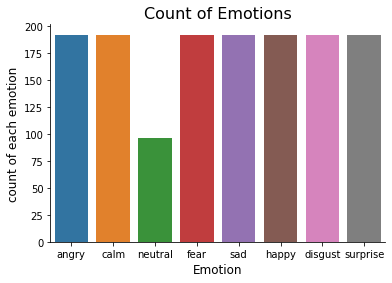

In [ ]:
plt.title('Count of Emotions', size=16)
sbn.countplot(data.Emotions)
plt.ylabel('count of each emotion', size=12)
plt.xlabel('Emotion', size=12)
sbn.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Waveplot is used to get the pitch of audio signal with respect to time.

Spectrogram is used to get the power spectrum movement of each audio. 

In [ ]:
def waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion (Pitch of audio)'.format(e), size=10)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def spectrogram(data, sr, e):
    X = librosa.stft(data)  # stft fis a function used to get the fourier trandform of signal
    Xdb = librosa.amplitude_to_db(abs(X)) #converting amplitute spectrum to db(decibel) 
    plt.figure(figsize=(10, 3))
    plt.title('Spectrogram for audio with {} emotion (power of audio)'.format(e), size=10)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

Spectrogram of Audio Signal:

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies.

Spectrogram tells about the quality fo sound. And this is seen with different colors at the different levels at a particular time.

Black-Red = Low Volume

Yellow-White = High Volume


For happy audio signal we can conclude from the spectrogram the following points:

The volume of the audio is low at the start and end of voice signals.

The volume is clear and loud in the middle of audio. 

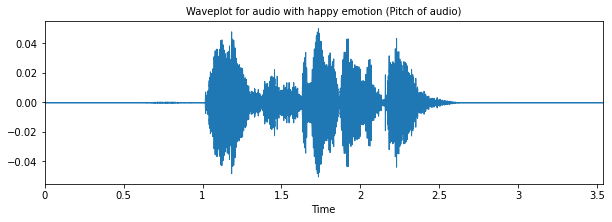

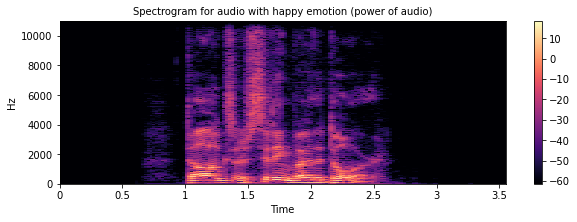

In [ ]:
emotion='happy'
path = np.array(data.Path[data.Emotions==emotion])[1]
data1, samplingRate = librosa.load(path)
waveplot(data1, samplingRate, emotion)
spectrogram(data1, samplingRate, emotion)
Audio(path)

For Angry signal:

The audio is too loud and the audio siganls clarity decreases with the frequnecy of audio signal.

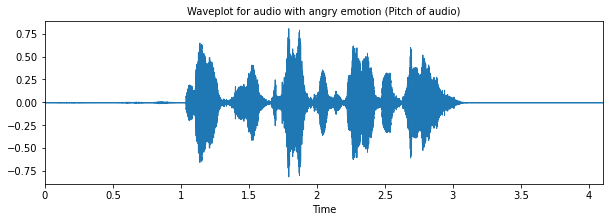

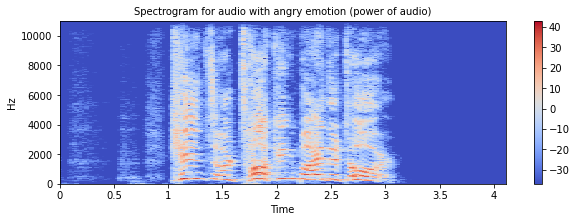

In [ ]:
emotion='angry'
path = np.array(data.Path[data.Emotions==emotion])[1]
data1, samplingRate = librosa.load(path)
waveplot(data1, samplingRate, emotion)
spectrogram(data1, samplingRate, emotion)
Audio(path)

For Sad audio signal:

The volumne of the signal is low and clarity decreases with the frequency.

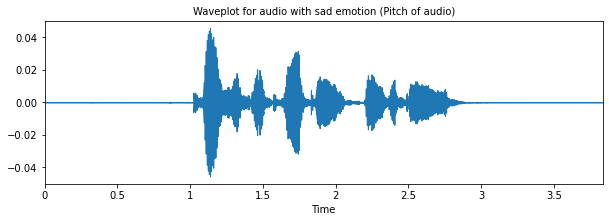

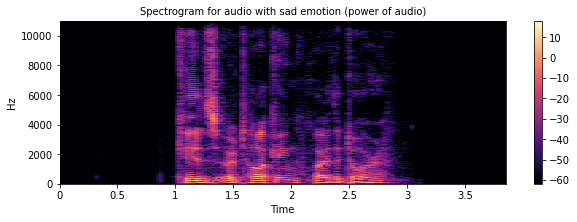

In [ ]:
emotion='sad'
path = np.array(data.Path[data.Emotions==emotion])[1]
data1, samplingRate = librosa.load(path)
waveplot(data1, samplingRate, emotion)
spectrogram(data1, samplingRate, emotion)
Audio(path)

For Fear signal:

The colume of audio is low and the statement has clarity for lowe frequency.

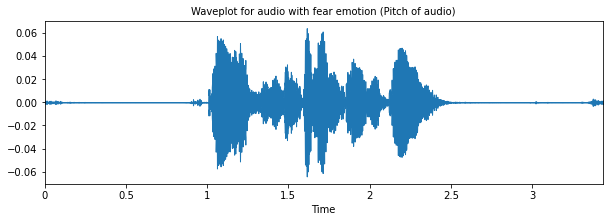

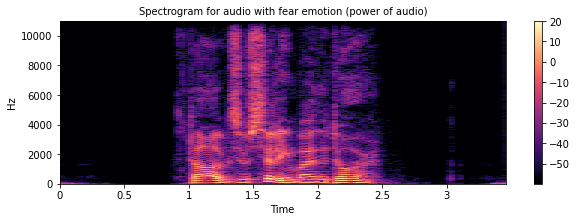

In [ ]:
emotion='fear'
path = np.array(data.Path[data.Emotions==emotion])[1]
data1, samplingRate = librosa.load(path)
waveplot(data1, samplingRate, emotion)
spectrogram(data1, samplingRate, emotion)
Audio(path)

Pitch, stretch, shift and noise are the data augmentations.

Data augmentations are the techniques are used to modify the data or add new sysnthetic data. These acts as regularizer and reduce the model from overfitting. 

In [ ]:
#noise  disturbance is added to the audio
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# stretch the audio by a fixed rate
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

# is used to shift the audio signal by some random seconds
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# changes pitch randomly 
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


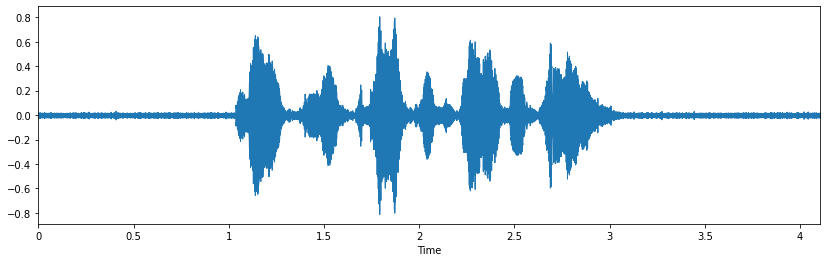

In [ ]:
path = np.array(data.Path)[1]
data1, sample_rate = librosa.load(path)
x = noise(data1)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

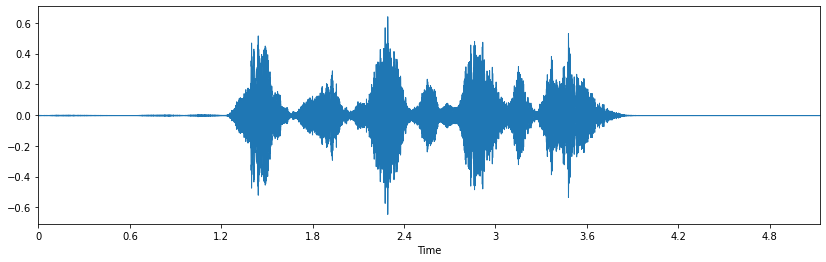

In [ ]:
path = np.array(data.Path)[1]
data1, sample_rate = librosa.load(path)
x = stretch(data1)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

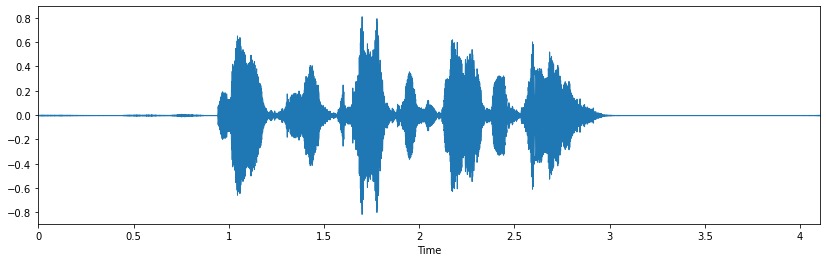

In [ ]:
path = np.array(data.Path)[1]
data1, sample_rate = librosa.load(path)
x = shift(data1)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

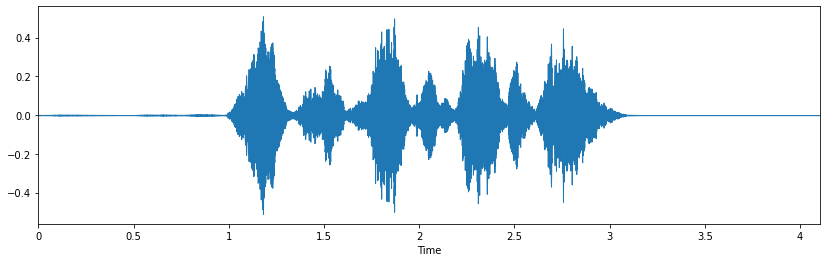

In [ ]:
path = np.array(data.Path)[1]
data1, sample_rate = librosa.load(path)
x = pitch(data1, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**Feature Extraction** with Data Augumentation added to dataset


Chroma: Chroma STFT The Chroma value of an audio basically represent the intensity of the audio signal. 

MFCC - is used in speech recognition systems and is also used in finding the audio similarity measures.

In [ ]:
def featureExtraction(data, sampleRate, chroma, mfcc, mel):
  # x, sampleRate = librosa.load(path)
  # data = x.read(dtype="float32")
  result=np.array([])
  if chroma:
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally
  if mfcc:
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))
  if mel:
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
  return result

def featureslist(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sampleRate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = featureExtraction(data, sampleRate, chroma=True, mfcc=True, mel=True)
    result = (res1)
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sampleRate)
    res3 = featureExtraction(data_stretch_pitch, sampleRate, chroma=True, mfcc=True, mel=True)
    result = np.vstack((result, res3))
    
    return result

In [ ]:
#{1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'} the emotions presents in dataset
emotionList=['angry', 'happy', 'sad', 'fear'] # considering only four emtions out of the whole list

In [ ]:
X, Y = [], []
for path, emotion in zip(data.Path, data.Emotions):
  if emotion not in emotionList:
    continue
  feature = featureslist(path)
  for element in feature:
      X.append(element)
      # adding two new audio files with data augmentation stretch an and pitch
      Y.append(emotion)

In [ ]:
X1 = X.copy()
Y1 = Y.copy()

In [ ]:
Features = pd.DataFrame(X1)
Features['labels'] = Y1
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,labels
0,0.573337,0.676871,0.717680,0.699399,0.650720,0.596740,0.574079,0.627749,0.648020,0.659353,0.624778,0.583435,-443.611084,66.393280,-4.908762,13.365290,-0.683898,-4.739339,-7.220381,-9.264338,-23.087978,-6.944154,-4.376257,-8.101152,-0.350776,-7.457047,-7.318939,1.527056,-14.205443,-1.777708,-3.192659,-6.974280,0.000062,0.000221,0.001155,0.009605,0.270380,0.621587,0.277373,0.216352,...,0.002857,0.002077,0.002477,0.003526,0.003342,0.004108,0.003758,0.003524,0.004210,0.004720,0.005386,0.006808,0.007126,0.009381,0.009312,0.006805,0.005292,0.004622,0.006171,0.005312,0.003137,0.002785,0.002037,0.001030,0.000834,0.001438,0.003769,0.006844,0.006002,0.006128,0.006578,0.004952,0.003148,0.002649,0.002409,0.001875,0.000917,0.000331,0.000027,angry
1,0.576244,0.545163,0.626019,0.712857,0.679925,0.602510,0.601830,0.572016,0.606453,0.648676,0.644013,0.609803,-493.869629,62.707451,-7.369641,12.254378,-3.103998,-5.103164,-9.360676,-14.818682,-25.508066,-4.139057,-5.107972,-6.039589,-0.220692,-9.853590,-5.395527,-2.900157,-15.968457,-0.646147,-6.405929,-8.372548,0.000015,0.000056,0.000201,0.000623,0.026228,0.121274,0.060138,0.060493,...,0.001359,0.000677,0.000536,0.000610,0.000601,0.000683,0.000505,0.000562,0.000610,0.000700,0.000843,0.001019,0.001169,0.000920,0.002343,0.002167,0.001616,0.001290,0.001220,0.000903,0.001314,0.001612,0.000675,0.000904,0.000315,0.000176,0.000247,0.000405,0.001291,0.001358,0.001251,0.001376,0.001501,0.001121,0.000699,0.000516,0.000471,0.000075,0.000003,angry
2,0.525608,0.575239,0.602346,0.654885,0.661421,0.598405,0.592498,0.648105,0.580586,0.511256,0.534184,0.543753,-229.149979,44.948467,-31.672752,0.850347,-20.263277,-8.151191,-21.009672,-18.356880,-21.367020,-12.744244,-10.382280,-6.440456,-11.590430,-9.068366,-8.646868,-1.193272,-12.326818,4.454832,2.348155,6.989972,0.022484,0.015843,0.008897,0.003956,0.008272,0.024631,0.027140,0.170274,...,0.213791,0.178837,0.112674,0.224075,0.142403,0.173730,0.230955,0.096040,0.051871,0.049384,0.047318,0.042377,0.078888,0.084151,0.081398,0.095939,0.059972,0.040099,0.032745,0.028883,0.023504,0.021871,0.029352,0.021394,0.011228,0.013261,0.023756,0.019402,0.016270,0.017089,0.017321,0.010100,0.006816,0.007732,0.006891,0.007043,0.008566,0.004409,0.000389,angry
3,0.542503,0.499363,0.555677,0.586966,0.657940,0.657452,0.584545,0.530462,0.627240,0.578710,0.482090,0.508848,-279.831604,39.603554,-34.668259,0.684691,-23.565168,-9.774626,-23.764200,-18.503176,-22.483902,-10.217191,-9.896710,-4.856725,-11.557173,-8.599206,-7.670332,-3.093660,-10.487440,9.857030,2.018539,10.170043,0.001894,0.001923,0.001565,0.001234,0.001271,0.003135,0.005376,0.015285,...,0.077311,0.040675,0.062712,0.023045,0.035698,0.041590,0.030714,0.044854,0.040426,0.014273,0.009401,0.011791,0.008858,0.012143,0.021642,0.013871,0.020582,0.013925,0.010497,0.008662,0.006726,0.006112,0.004800,0.005768,0.005976,0.003772,0.002528,0.003699,0.004176,0.003864,0.003615,0.004364,0.003665,0.001497,0.001158,0.001660,0.001061,0.000411,0.000036,angry
4,0.613513,0.678495,0.671709,0.658689,0.682340,0.661737,0.634338,0.636719,0.600956,0.579688,0.604910,0.616964,-415.906586,63.875664,-9.814710,13.458932,-6.323144,-4.840179,-12.036057,-12.570177,-21.317778,-9.669737,-7.581063,-9.690187,-6.077946,-6.912940,-7.660978,-4.344319,-13.746826,-2.372277,-9.281430,-6.395984,0.000360,0.000485,0.000936,0.012908,0.098118,0.345322,0.378172,0.253360,...,0.004721,0.002255,0.004393,0.003783,0.003159,0.005532,0.004428,0.005783,0.003595,0.004813,0.004807,0.004935,0.006848,0.005745,0.006134,0.006575,0.003712,0.001908,0.001475,0.000872,0.001413,0.001654,0.001259,0.001158,0.001136,0.000994,0.001173,0.001368,0.001353,0.000996,0.000579,0.000349,0.000489,0.000858,0.000871,0.000894,0.000501,0.0

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Features['labels'] = encoder.fit_transform(Features['labels'])
Features['labels'].unique()

array([0, 1, 3, 2])

In [ ]:
X_features = Features.iloc[: ,:-1].values
Y_labels = Features['labels'].values
print(Features['labels'].unique())

[0 1 3 2]


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
X_PCA = pca.fit_transform(X_features)
print(X_PCA.shape)

(1536, 40)


Splitting dataset to training and testing

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_PCA, Y_labels, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1152, 40), (1152,), (384, 40), (384,))

Model is build to train and test the model

In [ ]:
from sklearn import svm
lsvm = svm.SVC(kernel='linear', C=2).fit(x_train, y_train)
poly = svm.SVC(kernel='poly', degree=4, C=1).fit(x_train, y_train)

In [ ]:
poly_pred = poly.predict(x_test)
lsvm_pred = lsvm.predict(x_test)

Accuracy of Polynomial Kernel SVM

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  40.89
F1 (Polynomial Kernel):  37.87


Accuracy of Linear Kernel SVM

In [ ]:
lsvm_accuracy = accuracy_score(y_test, lsvm_pred)
lscmf1 = f1_score(y_test, lsvm_pred, average='weighted')
print('Accuracy (linear Kernel): ', "%.2f" % (lsvm_accuracy*100))
print('F1 (linear Kernel): ', "%.2f" % (lscmf1*100))

Accuracy (linear Kernel):  61.98
F1 (linear Kernel):  61.91


Confusion matrix for Linear kernel SVM

In [ ]:
print(metrics.confusion_matrix(y_test, lsvm_pred))

[[28  6  6  1]
 [ 4 25 10  9]
 [ 5 13 29  7]
 [ 1  6  5 37]]


**Feature extraction** with out Data agumnetation

In [ ]:
def featureExtraction1(path, chroma, mfcc, mel):
  data, sampleRate = librosa.load(path)
  if chroma:
    stft = np.abs(librosa.stft(data))
  result=np.array([])
  if mfcc:
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))
  if chroma:
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally
  if mel:
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
  return result

In [ ]:

, Y = [], []
for path, emotion in zip(data.Path, data.Emotions):
  if emotion not in emotionList:
    continue
  feature = featureExtraction1(path, chroma=True, mfcc=True, mel=True)
  X.append(feature)
  # adding two new audio files with data augmentation stretch an and pitch
  Y.append(emotion)
print(len(X))
print(len(Y))
# print(x_train.shape[1])

768
768


Splitting data to training and testing

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(Xa), Ya, test_size=0.2, random_state=9)

In [ ]:
print(x_train.shape)

(614, 180)


In [ ]:
Xa1 = X.copy()
Ya1 = Y.copy()
Features1 = pd.DataFrame(Xa1)
Features1['labels'] = Ya1
Features1.to_csv('features.csv', index=False)
Features1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,labels
0,-531.052979,44.653122,-3.249050,8.975468,-0.368288,-3.103155,-4.731602,-6.201691,-15.522319,-4.622941,-2.943895,-5.428802,-0.068439,-4.846159,-4.792139,1.188575,-9.502509,-1.188474,-1.985487,-4.616765,-6.534842,-0.391132,-4.664198,-3.331542,-3.409710,-2.430160,-5.902814,-1.229430,-3.386101,-1.017581,-1.143135,-0.894340,-0.175948,-1.830510,-2.952007,0.778081,-1.272715,1.216886,-1.633829,-1.287825,...,0.001917,0.001393,0.001662,0.002365,0.002242,0.002756,0.002521,0.002364,0.002824,0.003166,0.003613,0.004566,0.004780,0.006293,0.006246,0.004565,0.003550,0.003100,0.004139,0.003563,0.002104,0.001868,0.001366,0.000691,0.000559,0.000964,0.002528,0.004591,0.004026,0.004110,0.004412,0.003322,0.002112,0.001777,0.001616,0.001258,0.000615,0.000222,0.000018,angry
1,-349.332275,30.411381,-20.523148,1.312386,-11.870387,-3.827808,-13.357002,-13.008145,-14.113652,-7.955347,-6.107920,-4.512403,-7.562690,-5.354641,-4.481483,-0.198905,-7.983862,2.590233,1.732230,4.128476,2.864308,5.105248,3.749614,1.362520,-0.089763,1.070628,-2.359394,2.947479,1.647609,-0.593976,-0.405535,-0.280677,1.228367,0.818531,-2.763909,2.445463,1.668190,1.563855,-2.522500,-0.493118,...,0.130454,0.109126,0.068758,0.136723,0.086896,0.106009,0.140928,0.058605,0.031653,0.030139,0.028883,0.025865,0.048143,0.051354,0.049670,0.058542,0.036595,0.024469,0.019983,0.017626,0.014343,0.013347,0.017912,0.013056,0.006853,0.008093,0.014496,0.011839,0.009928,0.010428,0.010569,0.006164,0.004160,0.004719,0.004206,0.004299,0.005228,0.002691,0.000237,angry
2,-526.540344,40.550125,-5.846923,8.531040,-3.828484,-3.220251,-7.475060,-8.151177,-13.546168,-6.147716,-4.918255,-6.246776,-3.876451,-4.333686,-4.994554,-2.620617,-8.812981,-1.448637,-5.941490,-3.931993,-4.916208,-2.344001,-2.490675,-0.948195,-2.481981,0.087423,-3.468182,0.019803,-3.351007,-1.788560,-1.725938,-1.906409,-2.581398,-1.781037,-2.528097,1.557424,-0.203756,2.753887,-0.531201,1.065030,...,0.002999,0.001433,0.002791,0.002403,0.002007,0.003514,0.002813,0.003674,0.002284,0.003058,0.003054,0.003135,0.004350,0.003650,0.003897,0.004177,0.002358,0.001212,0.000937,0.000554,0.000897,0.001051,0.000800,0.000735,0.000722,0.000632,0.000745,0.000869,0.000860,0.000633,0.000368,0.000222,0.000311,0.000545,0.000554,0.000568,0.000318,0.000091,0.000008,angry
3,-603.511230,55.546986,-6.363470,9.471386,4.087012,-3.696825,-8.442776,-11.976025,-16.687145,-3.732369,-3.740829,-5.831695,-0.554758,-6.025747,-2.141191,2.954001,-7.681705,-3.937740,-2.685761,-2.912037,-6.224266,-1.294489,-4.720784,-4.653227,-3.577459,-1.657845,-5.777046,-0.522388,-3.778051,-2.436813,-4.118801,-1.308074,-2.758787,1.097758,-1.160232,1.544418,1.583813,1.618125,-1.718112,0.571052,...,0.000054,0.000045,0.000041,0.000044,0.000053,0.000038,0.000060,0.000067,0.000066,0.000089,0.000077,0.000068,0.000131,0.000176,0.000218,0.000307,0.000208,0.000149,0.000095,0.000072,0.000047,0.000025,0.000025,0.000032,0.000043,0.000036,0.000035,0.000037,0.000022,0.000023,0.000035,0.000034,0.000023,0.000016,0.000017,0.000028,0.000031,0.000014,0.000001,fear
4,-546.341675,42.903503,-6.407751,13.032621,-1.794448,-2.409417,-4.695904,-1.079173,-12.832335,-4.406177,-1.224013,-4.406079,-1.065066,-4.261331,-3.623211,-1.465830,-6.513277,-1.558025,-4.251171,-3.055878,-5.594828,-2.290184,-4.586450,-3.753849,-3.593025,-1.013455,-5.142197,1.492616,-2.491354,-0.602896,-0.196985,-0.195802,-2.351321,-1.542208,-2.637861,0.126800,-1.531270,-0.240219,-3.746547,-1.140426,...,0.000801,0.000645,0.000785,0.001222,0.001386,0.001949,0.003007,0.001652,0.001239,0.001741,0.001098,0.001676,0.002434,0.002240,0.001805,0.003143,0.001907,0.001219,0.000766,0.000412,0.000532,0.000688,0.000995,0.000545,0.000625,0.000302,0.000275,0.000191,0.000158,0.000109,0.000110,0.

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Features1['labels'] = encoder.fit_transform(Features1['labels'])
Features1['labels'].unique()

array([0, 1, 3, 2])

In [ ]:
X_features = Features1.iloc[: ,:-1].values
Y_labels = Features1['labels'].values
print(Features1['labels'].unique())

[0 1 3 2]


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
X_PCA = pca.fit_transform(X_features)
print(X_PCA.shape)

(768, 40)


**SVM model**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_PCA, Y_labels, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
from sklearn import svm
lsvm = svm.SVC(kernel='linear', C=2).fit(x_train, y_train)
poly = svm.SVC(kernel='poly', degree=4, C=1).fit(x_train, y_train)

In [ ]:
poly_pred = poly.predict(x_test)
lsvm_pred = lsvm.predict(x_test)

Accuracy of model with polynomial kernel

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  44.79
F1 (Polynomial Kernel):  40.83


Accuracy of model with linear kernel

In [ ]:
lsvm_accuracy = accuracy_score(y_test, lsvm_pred)
lscmf1 = f1_score(y_test, lsvm_pred, average='weighted')
print('Accuracy (linear Kernel): ', "%.2f" % (lsvm_accuracy*100))
print('F1 (linear Kernel): ', "%.2f" % (lscmf1*100))

Accuracy (linear Kernel):  61.98
F1 (linear Kernel):  61.91


Confusion matrix of Linear kernel

In [ ]:
print(metrics.confusion_matrix(y_test, lsvm_pred))

[[28  6  6  1]
 [ 4 25 10  9]
 [ 5 13 29  7]
 [ 1  6  5 37]]


Using MLPClassifier - this classifier has neural network build in it



In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(alpha=0.01,batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300, ), random_state=1, learning_rate='adaptive', max_iter=500)
clf.fit(x_train, y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500, random_state=1)

In [ ]:
mlpc_pred = clf.predict(x_test)

Accuracy

In [ ]:
mlpc_accuracy = accuracy_score(y_test, mlpc_pred)
print('Accuracy (linear Kernel): ', "%.2f" % (mlpc_accuracy*100))

Accuracy (linear Kernel):  81.25


Confusion matrix

In [ ]:
print(metrics.confusion_matrix(mlpc_pred, y_test))

[[96  3  4  2]
 [ 4 79  7  6]
 [ 6 11 72  7]
 [ 4  8 10 65]]
